In [110]:
import os
import math
from typing import Callable

import pandas as pd
import numpy as np
from fklearn.training.transformation import onehot_categorizer, custom_transformer, count_categorizer
from fklearn.training.regression import xgb_regression_learner, rf_regression_learner
from fklearn.training.pipeline import build_pipeline
from fklearn.validation.evaluators import r2_evaluator, mse_evaluator, combined_evaluators
from fklearn.training.imputation import imputer
from fklearn.preprocessing.splitting import time_split_dataset
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score

from helpers import (display_all, to_snake_case, add_date_parts,
                     tranform_columns_to_categorical, separate_features_by_dtype,
                    to_normalized_string, draw_tree)

In [2]:
def print_metrics(df_train: pd.DataFrame, df_test: pd.DataFrame, predict_fn: Callable):
    evaluator_fn = combined_evaluators(evaluators=[r2_evaluator(target_column="sale_price"),
                                                   mse_evaluator(target_column="sale_price")])
    df_train = predict_fn(df_train.copy())
    metrics_train = evaluator_fn(df_train)

    df_test = predict_fn(df_test.copy())
    metrics_test = evaluator_fn(df_test)

    print(f"""
Metrics Train:
    RMSE: {math.sqrt(metrics_train["mse_evaluator__sale_price"])}
    R2: {metrics_train["r2_evaluator__sale_price"]}
Metrics Test:
    RMSE: {math.sqrt(metrics_test["mse_evaluator__sale_price"])}
    R2: {metrics_test["r2_evaluator__sale_price"]}
""")

In [3]:
%load_ext autoreload
%autoreload 2

%matplotlib inline

In [4]:
DATA_PATH = "../data/bluebook-for-bulldozers/"

In [5]:
df_raw = pd.read_csv(f'{DATA_PATH}Train.csv', low_memory=False, parse_dates=["saledate"])

In [6]:
df_raw = df_raw.rename(mapper=to_snake_case, axis=1)

In [7]:
columns_dtype = separate_features_by_dtype(df_raw)
categorical_columns = columns_dtype["object"]

In [8]:
df_raw["sale_price"] = np.log(df_raw["sale_price"])
df_raw = add_date_parts(df_raw)
df_raw[categorical_columns] = df_raw[categorical_columns].applymap(str).applymap(to_normalized_string)
df_raw = tranform_columns_to_categorical(df_raw, ordered={"usage_band": ["high", "medium", "low"]})

In [9]:
display_all(df_raw.head().T)

,0,1,2,3,4
sales_id,1139246,1139248,1139249,1139251,1139253
sale_price,11.0974,10.9508,9.21034,10.5584,9.30565
machine_id,999089,117657,434808,1026470,1057373
model_id,3157,77,7009,332,17311
datasource,121,121,121,121,121
auctioneer_id,3,3,3,3,3
year_made,2004,1996,2001,2001,2007
machine_hours_current_meter,68,4640,2838,3486,722
usage_band,low,low,high,high,medium
saledate,2006-11-16 00:00:00,2004-03-26 00:00:00,2004-02-26 00:00:00,2011-05-19 00:00:00,2009-07-23 00:00:00


In [10]:
os.makedirs('tmp', exist_ok=True)
df_raw.to_feather('tmp/bulldozers-raw')

### Reload

In [78]:
SAMPLE_FRAC = 0.05

df_raw = pd.read_feather('tmp/bulldozers-raw')
df_raw = df_raw.sample(frac=SAMPLE_FRAC, random_state=1111)
columns_dtype = separate_features_by_dtype(df_raw)

print(f"Sample size: {len(df_raw)}")

Sample size: 20056


## Processors

### One-Hot Encoder

In [79]:
categorical_columns = columns_dtype["category"]
high_dimensional_columns = list(filter(lambda c: len(df_raw[c].unique()) > 100, categorical_columns))
categorical_columns = filter(lambda x: x not in high_dimensional_columns, categorical_columns)
categorical_columns = list(categorical_columns)

In [80]:
onehot_encoder_fn = onehot_categorizer(columns_to_categorize=categorical_columns,
                                       hardcode_nans=True,
                                       drop_first_column=True)

### Count encoder for high dimensional features

In [81]:
count_encoder_fn = count_categorizer(columns_to_categorize=high_dimensional_columns)

### Simple Continous Imputer

In [82]:
continuous_features = columns_dtype["float64"] + columns_dtype["int64"]
median_imputer_fn = imputer(columns_to_impute=continuous_features)

## Create Learners

### Feature Selection

In [83]:
banned_columns = ["sale_price", "sales_id"] + columns_dtype["datetime64[ns]"]

features = df_raw.columns
features = filter(lambda x: x not in banned_columns, features)
features = list(features)

### XGB Trainer

In [84]:
xgb_learner_fn = xgb_regression_learner(features=features,
                                        target="sale_price",
                                        encode_extra_cols=True)

### Random Forest Trainer

In [85]:
rf_learner_fn = rf_regression_learner(features=features,
                                      target="sale_price",
                                      encode_extra_cols=True,
                                      extra_params={"n_jobs": -1})

## Training

### Train vs Test

In [86]:
SAMPLE_FRAC = 0.1
train_test_row_limit = int(len(df_raw) * (1 - SAMPLE_FRAC))

train_start_date = df_raw["saledate"].min()
train_end_date = df_raw["saledate"].sort_values().reset_index(drop=True)[train_test_row_limit]
holdout_end_date = df_raw["saledate"].max()

df_train, df_test = time_split_dataset(
    df_raw,
    train_start_date=train_start_date,
    train_end_date=train_end_date,
    holdout_end_date=holdout_end_date,
    time_column="saledate"
)

print(f"Train Shape: {df_train.shape}, Test Shape: {df_test.shape}")

Train Shape: (18046, 65), Test Shape: (2008, 65)


### Training XGB

In [87]:
xgb_learner = build_pipeline(onehot_encoder_fn, count_encoder_fn, xgb_learner_fn)
predict_fn, _, logs = xgb_learner(df_train)
print_metrics(df_train, df_test, predict_fn)


Metrics Train:
    RMSE: 0.2357468218837586
    R2: 0.8843209578839231
Metrics Test:
    RMSE: 0.29526360764713594
    R2: 0.8312051171048468



### Training RF

In [88]:
rf_learner = build_pipeline(onehot_encoder_fn, count_encoder_fn, median_imputer_fn, rf_learner_fn)
predict_fn, _, logs = rf_learner(df_train)
print_metrics(df_train, df_test, predict_fn)

/Users/giuliano.ferrari/Documents/Other/fast-ai-ml-for-coders/.env/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)



Metrics Train:
    RMSE: 0.12221045737152553
    R2: 0.968912934426626
Metrics Test:
    RMSE: 0.3235161103855626
    R2: 0.7973571625767175



## Single Tree

In [89]:
params = {
    "n_jobs": -1,
    "n_estimators": 1,
    "max_depth": 3,
    "bootstrap": False,
}

single_tree_rf_learner_fn = rf_regression_learner(features=features,
                                      target="sale_price",
                                      encode_extra_cols=True,
                                      extra_params=params)

rf_learner = build_pipeline(onehot_encoder_fn, count_encoder_fn, median_imputer_fn, single_tree_rf_learner_fn)
predict_fn, df_s, logs = rf_learner(df_train)
print_metrics(df_train, df_test, predict_fn)


Metrics Train:
    RMSE: 0.5245428712618269
    R2: 0.4273029200793522
Metrics Test:
    RMSE: 0.5340921258216567
    R2: 0.44770414569476935



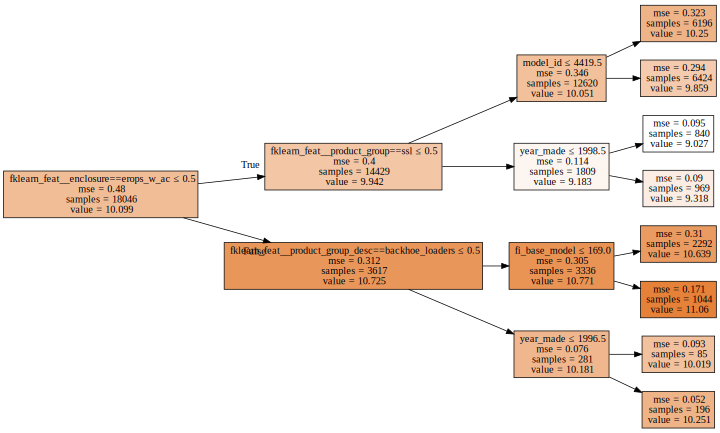

In [90]:
model_object = logs["rf_regression_learner"]["model_object"]
variables = logs["rf_regression_learner"]["features"]
draw_tree(model_object.estimators_[0], df_s[variables], precision=3)

In [91]:
params = {
    "n_jobs": -1,
    "n_estimators": 1,
    "bootstrap": False,
}

single_tree_rf_learner_fn = rf_regression_learner(
    features=features,
    target="sale_price",
    encode_extra_cols=True,
    extra_params=params
)

rf_learner = build_pipeline(onehot_encoder_fn, count_encoder_fn, median_imputer_fn, single_tree_rf_learner_fn)
predict_fn, _, logs = rf_learner(df_train)
print_metrics(df_train, df_test, predict_fn)


Metrics Train:
    RMSE: 4.580684275412833e-17
    R2: 1.0
Metrics Test:
    RMSE: 0.42612144146024733
    R2: 0.6484345341690974



## Bagging

### Intro to Bagging

In [99]:
rf_learner_fn = rf_regression_learner(features=features,
                                      target="sale_price",
                                      encode_extra_cols=True,
                                      extra_params={"n_jobs": -1})

rf_learner = build_pipeline(onehot_encoder_fn, count_encoder_fn, median_imputer_fn, rf_learner_fn)
predict_fn, _, logs = rf_learner(df_train)
print_metrics(df_train, df_test, predict_fn)

/Users/giuliano.ferrari/Documents/Other/fast-ai-ml-for-coders/.env/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)



Metrics Train:
    RMSE: 0.1243226037952974
    R2: 0.9678291018986815
Metrics Test:
    RMSE: 0.32449257723132163
    R2: 0.7961320450204752



In [105]:
preprocessor_learner = build_pipeline(onehot_encoder_fn, count_encoder_fn, median_imputer_fn)
preprocessor_fn, _, _ = preprocessor_learner(df_train)

model = logs["rf_regression_learner"]["model_object"]
columns = logs["rf_regression_learner"]["features"]

test_matrix_X = preprocessor_fn(df_test)[columns].values
test_vector_y = df_test["sale_price"].values

In [106]:
preds = np.stack([t.predict(test_matrix_X) for t in model.estimators_])

print(f"""
Prediction for the 10 trees: {preds[:,0]},
Mean prediction for the 10 trees: {np.mean(preds[:,0])}
Real value: {test_vector_y[0]}
""")


Prediction for the 10 trees: [9.30565055 9.35010231 9.74096862 9.85219426 9.59899836 9.30565055
 9.21034037 9.54681261 9.30565055 9.30565055],
Mean prediction for the 10 trees: 9.452201874500183
Real value: 9.350102314351341



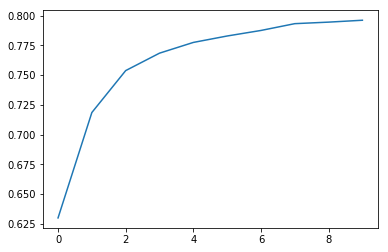

In [114]:
plt.plot([r2_score(test_vector_y, np.mean(preds[:i+1], axis=0)) for i in range(10)])

In [115]:
rf_learner_fn = rf_regression_learner(features=features,
                                      target="sale_price",
                                      encode_extra_cols=True,
                                      extra_params={"n_jobs": -1, "n_estimators": 20})

rf_learner = build_pipeline(onehot_encoder_fn, count_encoder_fn, median_imputer_fn, rf_learner_fn)
predict_fn, _, _ = rf_learner(df_train)
print_metrics(df_train, df_test, predict_fn)


Metrics Train:
    RMSE: 0.11228863163203918
    R2: 0.9737557256354042
Metrics Test:
    RMSE: 0.3148960957796908
    R2: 0.8080120438953486



In [116]:
rf_learner_fn = rf_regression_learner(features=features,
                                      target="sale_price",
                                      encode_extra_cols=True,
                                      extra_params={"n_jobs": -1, "n_estimators": 40})

rf_learner = build_pipeline(onehot_encoder_fn, count_encoder_fn, median_imputer_fn, rf_learner_fn)
predict_fn, _, _ = rf_learner(df_train)
print_metrics(df_train, df_test, predict_fn)


Metrics Train:
    RMSE: 0.10570561908189942
    R2: 0.9767427083768192
Metrics Test:
    RMSE: 0.30451216289769706
    R2: 0.8204651674465949



In [117]:
rf_learner_fn = rf_regression_learner(features=features,
                                      target="sale_price",
                                      encode_extra_cols=True,
                                      extra_params={"n_jobs": -1, "n_estimators": 80})

rf_learner = build_pipeline(onehot_encoder_fn, count_encoder_fn, median_imputer_fn, rf_learner_fn)
predict_fn, _, _ = rf_learner(df_train)
print_metrics(df_train, df_test, predict_fn)


Metrics Train:
    RMSE: 0.1032583367326997
    R2: 0.977807141668829
Metrics Test:
    RMSE: 0.3076455730895673
    R2: 0.8167513544919526



### OOB Score

In [120]:
rf_learner_fn = rf_regression_learner(features=features,
                                      target="sale_price",
                                      encode_extra_cols=True,
                                      extra_params={"n_jobs": -1, "n_estimators": 40, "oob_score": True})

rf_learner = build_pipeline(onehot_encoder_fn, count_encoder_fn, median_imputer_fn, rf_learner_fn)
predict_fn, _, logs = rf_learner(df_train)
print_metrics(df_train, df_test, predict_fn)

oob_score = logs["rf_regression_learner"]["model_object"].oob_score_
print(f"OOB R2: {oob_score}")


Metrics Train:
    RMSE: 0.10569853820610059
    R2: 0.9767458241331824
Metrics Test:
    RMSE: 0.30746315994700135
    R2: 0.8169685983221957

OOB R2: 0.8330105626551287


## Reducing Overfitting

In [125]:
from sklearn.ensemble import forest


def set_rf_samples(n):
    """ Changes Scikit learn's random forests to give each tree a random sample of
    n random rows.
    """
    forest._generate_sample_indices = (lambda rs, n_samples:
        forest.check_random_state(rs).randint(0, n_samples, n))

def reset_rf_samples():
    """ Undoes the changes produced by set_rf_samples.
    """
    forest._generate_sample_indices = (lambda rs, n_samples:
        forest.check_random_state(rs).randint(0, n_samples, n_samples))

### Subsampling

In [132]:
df_raw = pd.read_feather('tmp/bulldozers-raw')
set_rf_samples(20000)

In [133]:
train_test_row_limit = int(len(df_raw) - 12000)

train_start_date = df_raw["saledate"].min()
train_end_date = df_raw["saledate"].sort_values().reset_index(drop=True)[train_test_row_limit]
holdout_end_date = df_raw["saledate"].max()

df_train, df_test = time_split_dataset(
    df_raw,
    train_start_date=train_start_date,
    train_end_date=train_end_date,
    holdout_end_date=holdout_end_date,
    time_column="saledate"
)

print(f"Train Shape: {df_train.shape}, Test Shape: {df_test.shape}")

Train Shape: (389050, 65), Test Shape: (12015, 65)


In [134]:
rf_learner_fn = rf_regression_learner(features=features,
                                      target="sale_price",
                                      encode_extra_cols=True,
                                      extra_params={"n_jobs": -1, "oob_score": True})

rf_learner = build_pipeline(onehot_encoder_fn, count_encoder_fn, median_imputer_fn, rf_learner_fn)
predict_fn, _, logs = rf_learner(df_train)
print_metrics(df_train, df_test, predict_fn)

oob_score = logs["rf_regression_learner"]["model_object"].oob_score_
print(f"OOB R2: {oob_score}")

/Users/giuliano.ferrari/Documents/Other/fast-ai-ml-for-coders/.env/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)



Metrics Train:
    RMSE: 0.24751515043855032
    R2: 0.8722693288513845
Metrics Test:
    RMSE: 0.28985504307061966
    R2: 0.8391918734289987

OOB R2: 0.8589772297237845


In [136]:
rf_learner_fn = rf_regression_learner(features=features,
                                      target="sale_price",
                                      encode_extra_cols=True,
                                      extra_params={"n_jobs": -1, "oob_score": True, "n_estimators": 40})

rf_learner = build_pipeline(onehot_encoder_fn, count_encoder_fn, median_imputer_fn, rf_learner_fn)
predict_fn, _, logs = rf_learner(df_train)
print_metrics(df_train, df_test, predict_fn)

oob_score = logs["rf_regression_learner"]["model_object"].oob_score_
print(f"OOB R2: {oob_score}")


Metrics Train:
    RMSE: 0.23332077296002912
    R2: 0.8864993280774466
Metrics Test:
    RMSE: 0.2738768908782069
    R2: 0.8564321989366221

OOB R2: 0.8744004645667023


In [137]:
reset_rf_samples()

### Tree building parameters

In [138]:
rf_learner_fn = rf_regression_learner(features=features,
                                      target="sale_price",
                                      encode_extra_cols=True,
                                      extra_params={"n_jobs": -1, "oob_score": True, "n_estimators": 40, "min_samples_leaf": 5})

rf_learner = build_pipeline(onehot_encoder_fn, count_encoder_fn, median_imputer_fn, rf_learner_fn)
predict_fn, _, logs = rf_learner(df_train)
print_metrics(df_train, df_test, predict_fn)

oob_score = logs["rf_regression_learner"]["model_object"].oob_score_
print(f"OOB R2: {oob_score}")


Metrics Train:
    RMSE: 0.1486250513687085
    R2: 0.9539451200076411
Metrics Test:
    RMSE: 0.24598023229458524
    R2: 0.8841898337038445

OOB R2: 0.9024323594269485


In [139]:
rf_learner_fn = rf_regression_learner(features=features,
                                      target="sale_price",
                                      encode_extra_cols=True,
                                      extra_params={"n_jobs": -1, "oob_score": True, "n_estimators": 40, "min_samples_leaf": 3})

rf_learner = build_pipeline(onehot_encoder_fn, count_encoder_fn, median_imputer_fn, rf_learner_fn)
predict_fn, _, logs = rf_learner(df_train)
print_metrics(df_train, df_test, predict_fn)

oob_score = logs["rf_regression_learner"]["model_object"].oob_score_
print(f"OOB R2: {oob_score}")


Metrics Train:
    RMSE: 0.12141529421295852
    R2: 0.9692646323332034
Metrics Test:
    RMSE: 0.24562335212451605
    R2: 0.8845256360519338

OOB R2: 0.9047598370128167


In [140]:
rf_learner_fn = rf_regression_learner(features=features,
                                      target="sale_price",
                                      encode_extra_cols=True,
                                      extra_params={"n_jobs": -1,
                                                    "oob_score": True,
                                                    "n_estimators": 40,
                                                    "min_samples_leaf": 3,
                                                    "max_features": 0.5})

rf_learner = build_pipeline(onehot_encoder_fn, count_encoder_fn, median_imputer_fn, rf_learner_fn)
predict_fn, _, logs = rf_learner(df_train)
print_metrics(df_train, df_test, predict_fn)

oob_score = logs["rf_regression_learner"]["model_object"].oob_score_
print(f"OOB R2: {oob_score}")


Metrics Train:
    RMSE: 0.1266079147876798
    R2: 0.9665794700915848
Metrics Test:
    RMSE: 0.23977024826955698
    R2: 0.8899634775779887

OOB R2: 0.9070494862643644
